In [108]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.fftpack import idct

Variable initialization

In [109]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [110]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    DCT[:, i] = temp/norm


Generating the 1-D standard basis

In [111]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

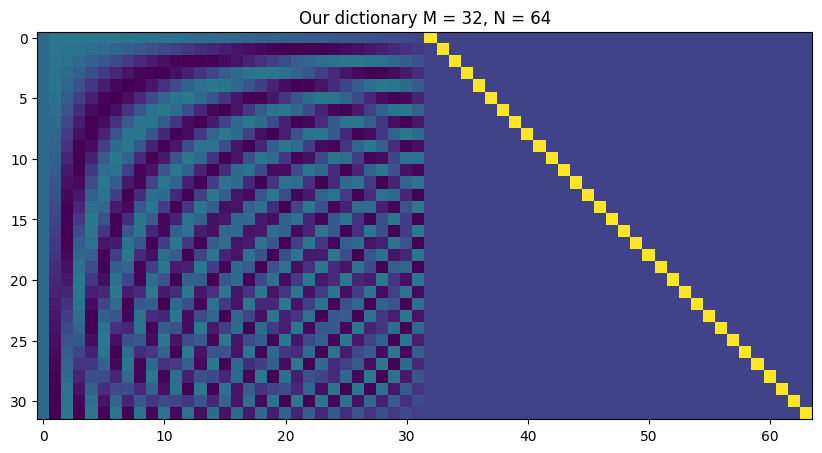

In [112]:
D = np.hstack((DCT, C)) # A = np.concatenate((C, D), axis=1)

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [113]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [114]:
x0 = np.zeros(N)
positions = np.random.choice(M, L, replace=False)
x0[positions] = np.random.rand(L)
x0

array([0.86123987, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05930297, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.61609553,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16300394, 0.        , 0.        , 0.        , 0.        ,
       0.76548367, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])



Choose spike location and update x0

In [115]:
spikeLocation = np.random.choice(positions)
print(spikeLocation)
#add spike to x0
# lambda_spike = np.random.uniform(3,4) + (2*np.abs(max(x0))/x0[spikeLocation]) # para que al menos sea el doble de la señal mas intensa
# x0[spikeLocation] = lambda_spike * x0[spikeLocation]
# x0

19


Synthetize the corresponding signal in the signal domain and add noise


In [116]:
# s0 = Dx
s0 = np.dot(D,x0) # noise free
print(s0.shape)

#add spike to s0
lambda_spike = np.random.uniform(3,4) + (2*np.abs(max(s0))/s0[spikeLocation]) # para que al menos sea el doble de la señal mas intensa
s0[spikeLocation] = lambda_spike * s0[spikeLocation]
print(s0)

# add noise
sigma = 10/255
sigma_noise = sigma * (np.random.normal(size=s0.shape))

# s = s0 + eta
s = s0 + sigma_noise
print(s.shape)

(32,)
[ 0.29018248 -0.0776049   0.26953752  0.1391868   0.20929711 -0.10136129
  0.44075747  0.03493337  0.18661366  0.03074217  0.46220332 -0.18219437
  0.2527241   0.20422089  0.14063347  0.06184241  0.232531    0.28631202
 -0.091497    1.86793863  0.16343081  0.16849199 -0.08116186  0.52617385
 -0.08394353  0.24134504  0.05696027  0.3636662  -0.10489578  0.20403288
  0.28234222  0.07922145]
(32,)


Plot the sparse signal

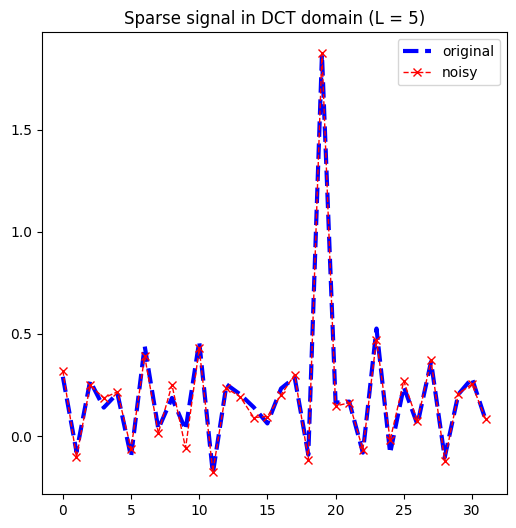

In [117]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [118]:
x_MP = np.zeros(N)

r = s - np.dot(D,x_MP)
print(r)
print(r.shape)
l = 1 # cont

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = np.linalg.norm(r)

MINIMUM_RES_NORM = 0.1

[ 0.31994854 -0.10415735  0.24875153  0.18625081  0.21634968 -0.06175139
  0.39144062  0.0140236   0.25054402 -0.05843639  0.42895919 -0.1742633
  0.234078    0.19218688  0.09059638  0.09561388  0.20102143  0.30053764
 -0.1156558   1.8733816   0.14646894  0.16309985 -0.06666157  0.47240796
 -0.01975408  0.26920984  0.07268013  0.37119352 -0.12070216  0.20681034
  0.25434305  0.08295972]
(32,)


MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [119]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:
    print(f"Cycle:{l}")

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        argmax = np.dot(r.T, dj) / np.linalg.norm(dj)**2 # dot product between 2 vectors = escalar
        # e[j] = np.linalg.norm(r)**2 - argmax**2 # Prof. Diego version
        e[j] =  np.linalg.norm(r) - argmax # Prof. Giacomo
        # this corresponds to solving e(j) = min( || dj zj - s ||),
        # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
        # there is no need to divide by || dj ||^2 since columns are nomalized

    # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
    jStar = np.argmin(e) # index where the minimum value of e is located

    # find zjStar and djStar
    djStar = D[:,jStar]
    zjStar = np.dot(r.T,djStar) / np.linalg.norm(djStar)**2 
    
    # test if: zjstar*ejstar = zjstar
    # ejstar = np.dot(zjStar,C[:,jStar])
    # # z_prueba = zjStar * ejstar
    # print(zjStar)
    # print(z_prueba)    
    
    # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
    x_MP[jStar] = x_MP[jStar] + zjStar #* 1  #ejStar (position jstar in cannonical )

    # remove the signal we have so far represented in coeff_MP (update the residual)
    r = s - np.dot(D,x_MP)
    # r = r - (zjStar*djStar) - s # component that cannot be captured by the signal (the signal at the very beginning)

    l = l + 1

    # update the residual norm
    resNorm = np.linalg.norm(r)
    print()

Cycle:1

Cycle:2

Cycle:3

Cycle:4

Cycle:5



SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [120]:
s_hat_MP = np.dot(D,x_MP)
s_hat_MP

array([ 0.25511582, -0.08172777,  0.26715912,  0.12497367,  0.21009394,
       -0.0763154 ,  0.38251933,  0.02977307,  0.16109974,  0.01635209,
        0.43707148, -0.16297455,  0.2572366 ,  0.18429226,  0.12007368,
        0.06214072,  0.18367674,  0.26316425, -0.07061428,  2.12116338,
        0.16991108,  0.15554735, -0.07450857,  0.47160316, -0.10146429,
        0.23664883,  0.04470826,  0.34398122, -0.06898037,  0.18017458,
        0.25950152,  0.06007841])

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [121]:
resNorm_MP = np.linalg.norm(r)


Show the result

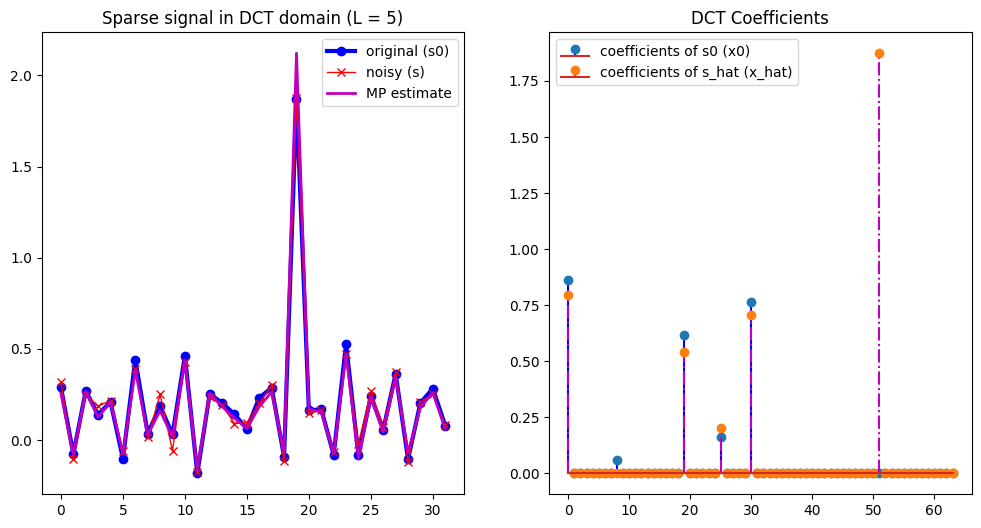

In [122]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

